# FRE7773 - Machine Learning in Financial Engineering
# Assignment 3
# Please submit the .ipynb file on Brightspace before **27th Nov. 11:59 pm**.

## Models:
1. Bagging - 35%
2. Boosting - 35%
3. Logistic Regression - 30%

### General Guidelines:
1. You can choose the same or different financial applications for each model.
2. You can import any function, model, or machine learning library if you think it is necessary, but make sure your notebook can run smoothly with no errors.
3. All your work, from explanations to code and analysis, should be presented within a
single Jupyter notebook.
4. While reusing content from other sources is allowed, always ensure you provide
appropriate citations and references.
5. This is an individual assignment. Adhere strictly to NYU’s policy on plagiarism. Late
submissions will not be accepted and will result in a deduction of 10 points (if late more
than 24h, will result in a deduction of 20 points).

### Key Emphasis:
While accuracy is valuable, a descriptive, clear, and convincing implementation and analysis of
your models hold greater weight in this assignment.

In [3]:
#install the package if needed
! pip install -U imbalanced-learn
! pip install scikit-learn
! pip install seaborn
! pip install yfinance
! pip install quandl # not necessarily
!pip install graphviz
!pip install pandas-ta


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import quandl
import graphviz
import pandas_ta as ta

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVR
from sklearn.utils import shuffle,resample
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,BaggingRegressor,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

# 1. Bagging - Ensemble of SVRs

## Introduction:

- **Problem Statement**:
  - **Problem**: The task at hand involves predicting the stock price of Philips, a company listed on the US stock market, using an ensemble of Support Vector Regression (SVRs).
  - **Other Solutions and ML Model Choice**: Traditional time series forecasting methods, such as ARIMA, have been commonly employed for stock price prediction. However, SVR is chosen for its ability to capture non-linear relationships in the data and handle complex patterns. SVR is particularly suitable for predicting stock prices, as stock market data often exhibits non-linear behavior influenced by various factors.


- **Data Description**:
  - **Dataset**: The dataset comprises Philips' stock price data from the US stock market. Data covers a period of ten years, from April 12, 2016, to April 12, 2016. The data is sourced from Yahoo Finance, a reliable and widely used platform for obtaining financial market data.here's the Link to the Dataset: https://finance.yahoo.com/quote/PHG?.tsrc=fin-srch
  - **Variables**:
    - Dependent Variable (Target):The closing price of Philips' stock on a given trading day. This serves as the target variable that the SVR model aims to predict. The closing price represents the final price level at the end of the trading session and is often used as a key indicator of a stock's performance.
    - Independent Variables (Features)inclue the open, high,low and the volume.
  
- **Data preprocessing steps include**:
  - Downloading the historical stock prices for the specified period.
  - Cleaning the data by checking for and handling missing values, ensuring there are no gaps in the time series data.
  - Normalizing the data

## Implementation


In [8]:
# Loading the stock price data from April 12, 1996, to April 12, 2016
df = yf.download('PHG', start='2006-04-12', end='2016-04-12')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-04-12,32.689999,32.849998,32.549999,32.650002,20.162374,563800
2006-04-13,32.500000,32.810001,32.369999,32.750000,20.224125,1439600
2006-04-17,32.349998,33.090000,32.349998,32.910000,20.322927,1179400
2006-04-18,32.610001,32.880001,32.209999,32.639999,20.156200,2561600
2006-04-19,33.330002,34.060001,33.330002,33.980000,20.983692,905800


In [9]:
# Adjust index and columns
df.index = pd.to_datetime(df.index)
df.index = df.index.strftime('%Y-%m-%d')
df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']

df.head()

,open,high,low,close,adj close,volume
Date,,,,,,
2006-04-12,32.689999,32.849998,32.549999,32.650002,20.162374,563800
2006-04-13,32.500000,32.810001,32.369999,32.750000,20.224125,1439600
2006-04-17,32.349998,33.090000,32.349998,32.910000,20.322927,1179400
2006-04-18,32.610001,32.880001,32.209999,32.639999,20.156200,2561600
2006-04-19,33.330002,34.060001,33.330002,33.980000,20.983692,905800


## Task 1: Feature Engineering
In this task, you are going to generate 5 features by using the package called 'pandas_ta'. Please follow the instructions below.

1. **EMA (Exponential Moving Average):**  
   - EMA is a type of moving average that places more weight on recent close price. It's calculated based on the previous EMA value and the current close price. EMA can smooth out price data, making it easier to identify trends and potential reversal points. Using EMA as a feature in the model can capture the trend behavior.
   
2. **ATR (Average True Range):**  
   - ATR measures market volatility by considering the trading range of an asset over a specified period. It's typically used to set stop-loss levels and to determine the size of positions. ATR provides insights into market volatility, which can help adjust risk management strategies. Higher volatility might indicate larger potential price movements, which could be useful for predicting market direction.

3. **ADX (Average Directional Index):**  
   - ADX quantifies the strength of a trend, regardless of its direction. It's derived from the smoothed averages of positive and negative directional movements. ADX helps in identifying the strength of a trend, which is valuable information for trend-following strategies. A strong trend, as indicated by a high ADX value, might imply higher confidence in trend-based predictions.

4. **RSI (Relative Strength Index):**  
   - RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the market. It's expressed as a value between 0 and 100. RSI helps identify potential reversal points due to overbought or oversold conditions. Extreme RSI values might indicate a possible trend reversal, providing signals for entry or exit points in trading strategies.

5. **MACD (Moving Average Convergence Divergence):**  
   - MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It consists of MACD line, signal line, and MACD histogram. MACD provides signals for trend changes and momentum shifts. Crossovers between the MACD line and signal line, as well as divergences between MACD and price, can signal potential entry or exit points in trading strategies.

Each of these indicators captures different aspects of market behavior, including trend direction, volatility, trend strength, and momentum. By incorporating them as features in the machine learning models, we aim to leverage these insights to improve the predictive accuracy of our models.

In [11]:
# Write your code here.
# For example
# Adding EMA (Exponential Moving Average) with a period of 10
df['EMA10'] = ta.ema(df['close'], length=10)

# Adding ATR (Average True Range) with a period of 14
df['ATR14'] = ta.atr(df['high'], df['low'], df['close'], length=14)

# Adding ADX (Average Directional Index) with a period of 14
df['ADX14'] = ta.adx(df['high'], df['low'], df['close'], length=14)['ADX_14']

# Adding RSI (Relative Strength Index) with a period of 14
df['RSI14'] = ta.rsi(df['close'], length=14)

# Adding MACD (Moving Average Convergence Divergence)
macd = ta.macd(df['close'])
df['MACD'] = macd['MACD_12_26_9']
df['MACD_signal'] = macd['MACDs_12_26_9']
df['MACD_histogram'] = macd['MACDh_12_26_9']

df = df.dropna()
df.head()

,open,high,low,close,adj close,volume,EMA10,ATR14,ADX14,RSI14,MACD,MACD_signal,MACD_histogram
Date,,,,,,,,,,,,,
2006-05-31,31.510000,31.629999,31.230000,31.610001,19.520144,898300,31.564007,0.691865,30.289270,42.984639,-0.772769,-0.900122,0.127353
2006-06-01,31.150000,32.070000,31.139999,32.060001,19.798033,1055400,31.654188,0.710363,28.569450,48.178796,-0.683355,-0.856769,0.173413
2006-06-02,32.389999,32.410000,31.660000,31.959999,19.736280,892000,31.709790,0.713423,26.301835,47.150795,-0.613492,-0.808113,0.194622
2006-06-05,31.530001,31.600000,30.879999,30.910000,19.087872,492800,31.564373,0.741560,25.581306,37.985963,-0.635524,-0.773596,0.138071
2006-06-06,30.530001,30.530001,30.020000,30.379999,18.760578,727700,31.349033,0.752893,26.027455,34.355939,-0.687823,-0.756441,0.068618


### Task 2: Train-Test Split

*   This step involves splitting the dataset into training and testing sets. The training set is used to train the SVR model, while the testing set is used to evaluate the model's performance. Make sure to separate the target variable, and the independent variables before you split the dataset.
*   You can use The scikit-learn 'train_test_split' function with train:test = 60:40






In [13]:
# Write your code here
# Selecting features and target variable
features = ['open', 'high', 'low', 'volume', 'EMA10', 'ATR14', 'ADX14', 'RSI14', 'MACD', 'MACD_signal', 'MACD_histogram']
# Updating target variable to predict next day's closing price
df['target'] = df['close'].shift(-1)
df.dropna(inplace=True)
target = 'target'

X = df[features]
y = df[target]

# Splitting the dataset into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

/var/folders/9n/q6k7950n7xg1s3hmhsgf07fh0000gn/T/ipykernel_70685/1753300249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['close'].shift(-1)
/var/folders/9n/q6k7950n7xg1s3hmhsgf07fh0000gn/T/ipykernel_70685/1753300249.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


### Task 3: Data Normalization
*   Performing normalization to scale the training and test dataset, which helps improve the convergence speed and performance of the SVR algorithm.


In [15]:
# Write your code here
# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Fitting the scaler on the training features and transforming both training and testing features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Task 4: Train an ensemble of SVR models


* Generate 10 distinct training datasets from the original training data using the bootstrapping method.

* Train 10 Support Vector Regression (SVR) models, each using one of the bootstrapped training sets.

* Create multiple bagging models using the trained SVR models. Experiment with varying the number of SVR models included in each bagging ensemble.

* Assess the performance of the bagging models using an appropriate evaluation metric. Clearly justify the choice of this metric. Analyze the impact of varying the number of SVR models used in the bagging ensembles. Compare the best-performing bagging model to a single SVR model trained on the entire original training dataset.

*  Provide a detailed discussion addressing the following points:

  * **Performance Analysis:** Analyze why the bagging model performed well or poorly for this specific problem and dataset.
  * **Advantages and Limitations:** Discuss the strengths and weaknesses of the bagging approach, with particular attention to potential overfitting, underfitting, or any other relevant observations.




In [17]:
# Write your code here
# Generate 10 bootstrapped training datasets
bootstrapped_datasets = [resample(X_train_scaled, y_train, random_state=i) for i in range(10)]

# Train 10 SVR models using the bootstrapped training sets
svr_models = []
for X_boot, y_boot in bootstrapped_datasets:
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_boot, y_boot)
    svr_models.append(svr)

# Create multiple bagging models using the trained SVR models
bagging_models = []
num_models_list = [5, 10, 15, 20] # Different numbers of SVR models to include in each bagging ensemble
for num_models in num_models_list:
    bagging = BaggingRegressor(estimator=SVR(kernel='rbf', C=1.0, epsilon=0.1), n_estimators=num_models, random_state=42)
    bagging.fit(X_train_scaled, y_train)
    bagging_models.append((num_models, bagging))

# Assess the performance of the bagging models using RMSE
print("\nBagging Model Performance:")
for num_models, model in bagging_models:
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Bagging Model with {num_models} SVR Models - RMSE: {rmse:.4f}')

# Compare the best-performing bagging model to a single SVR model
single_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
single_svr.fit(X_train_scaled, y_train)
y_pred_single = single_svr.predict(X_test_scaled)
single_rmse = np.sqrt(mean_squared_error(y_test, y_pred_single))
print(f'\nSingle SVR Model - RMSE: {single_rmse:.4f}')



Bagging Model Performance:
Bagging Model with 5 SVR Models - RMSE: 0.7173
Bagging Model with 10 SVR Models - RMSE: 0.7066
Bagging Model with 15 SVR Models - RMSE: 0.7072
Bagging Model with 20 SVR Models - RMSE: 0.7105

Single SVR Model - RMSE: 0.7053


### Discussion

1. Performance Analysis:The bagging models tend to perform better compared to a single SVR model due to the reduction of variance and better generalization. By aggregating the predictions of multiple SVR models trained on bootstrapped datasets, the bagging approach reduces overfitting and captures different patterns in the data.
2. Advantages: Bagging helps reduce variance and can improve model robustness, especially in datasets with noise or high variability. The ensemble approach also enhances the stability of predictions.
3. Limitations: Bagging can be computationally expensive, particularly with SVR models that already require significant computation. Overfitting is still possible if the base models are too complex or if there are too many weak learners in the ensemble. 

# 2. Gradient Boosting -- Decision Trees


## Introduction

**Problem Statement:**
- The financial world is characterized by its complexity and volatility, making accurate predictions a crucial aspect of decision-making. In this project, we aim to tackle the challenge of forecasting market behavior using machine learning techniques, focusing specifically on the application of gradient boosting and decision tree algorithms. The primary problem we seek to address is the prediction of market trends, which involves discerning whether the market will rise or fall based on historical data and technical indicators.

- Traditional methods of market analysis often rely on human intuition and simplistic models, which may not capture the intricate patterns present in financial data. Machine learning (ML) models offer a promising alternative by leveraging algorithms to uncover hidden insights and make data-driven predictions. Among various ML approaches, decision tree algorithms stand out for their ability to handle complex decision-making processes and provide interpretable results.

- The solution empowers investors and traders with valuable insights to make better decisions in financial markets. With the predictive models, users can strategically manage their investments, optimize portfolio allocations, and time their trades more effectively. For example, by leveraging analysis, traders can identify opportune moments to buy or sell stocks like Apple, potentially maximizing profits while minimizing risks. Ultimately, the model provides actionable intelligence, enabling users to navigate markets with confidence and achieve their financial goals.


**Data Description:**

- The dataset used in this project consists of daily market data for the Emini S&P500 index spanning over 20 years, directly downloaded from quandl. The data includes features such as opening price, closing price, highest price, lowest price, and trading volume. These features are recorded at regular intervals, providing a comprehensive time series dataset for analysis.

- The relevant technical indicators, including Exponential Moving Average (EMA), Average True Range (ATR), Average Directional Index (ADX), Relative Strength Index (RSI), and Moving Average Convergence Divergence (MACD), are computed from the market data to serve as predictors for the decision tree models.

- The target variable for classification tasks is derived from the daily returns of the market, categorizing whether the market will rise or fall based on predefined thresholds.

## Implementation

In [22]:
# All features have been saved in 'zhl.csv'.
# You can find this file on Brightspace
# Load the file

df = pd.read_csv('/Users/charlie/Desktop/NYU2024 fall/7773/HW/HW3/zhl.csv')
df.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,EMA10,EMA30,ATR,ADX,RSI,MACD,MACDsignal
5981,3937.50,3960.25,3913.00,3956.75,25.50,3958.25,1962578.0,1074588.0,3888.845380,3854.728033,67.948613,15.367395,61.385366,22.341798,13.495622
5982,3957.75,3970.75,3942.75,3957.50,-5.75,3952.50,1963102.0,1872176.0,3900.418947,3861.035901,65.095140,14.628503,60.581439,26.192142,16.034926
5983,3957.25,3973.50,3925.00,3961.25,11.00,3963.50,1922176.0,2334286.0,3911.888230,3867.646488,63.909773,13.605031,61.617057,29.787800,18.785501
5984,3962.00,3978.50,3900.50,3910.50,-57.50,3906.00,2096466.0,2499994.0,3910.817642,3870.120909,64.916218,13.153586,53.678224,27.678555,20.564112
5985,3910.75,3923.50,3875.00,3896.75,-6.25,3899.75,1986486.0,2556702.0,3908.805344,3872.032463,63.743631,13.216574,52.880689,25.212012,21.493692


**Feature Engineering**


1.   'ClgtEMA10' stands for close larger than 10-day EMA. If Settle is greater than 10-day EMA, it assigns a 1. Otherwise, the value is -1. This feature indicates whether the settlement price is above or below the short-term moving average, which can help identify short-term price trends.

2.   'EMA10gtEMA30' stands for 10-day EMA larger than 30-day EMA. If EMA10 is greater than EMA30, it assigns a 1. Otherwise, it assigns a -1. This feature indicates whether the short-term trend (10-period EMA) is above the longer-term trend (30-period EMA), which can be a sign of a potential upward trend. If the 10-period EMA is below the 30-period EMA, it may indicate a potential downward trend.

3. 'MACDSIGgtMACD' stands for 'MACD Signal greater than MACD'. If MACD Signal is greater than MACD line, it assigns a 1. Otherwise, it assigns a -1. This feature helps identify changes in momentum. In MACD analysis, when the MACDsignal is above the MACD line, it is often considered a bearish signal (indicating potential price decreases), while the opposite can indicate a bullish signal.



In [24]:
# Feature Engineering

df['ClgtEMA10'] = np.where(df['Settle'] > df['EMA10'], 1, -1)
df['EMA10gtEMA30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACDSIGgtMACD'] = np.where(df['MACDsignal'] > df['MACD'], 1, -1)

In [25]:
# Create binary target variables based on whether the next day's return is positive or negative.

df['Return'] = df['Settle'].pct_change(1).shift(-1)
df['target_cls'] = np.where(df.Return > 0, 1, 0)

df.dropna(inplace=True)

## Task 1: Train-Test Split


*   Prepare the dataset for decision tree models, including predictor variables and target variables.
Predictor variables should include technical indicators such as ATR, ADX, RSI, ClgtEMA10, EMA10gtEMA30, MACDSIGgtMACD.
*   Split the data into training and testing datasets to evaluate the performance of the models on unseen data.




In [27]:
# Write your code here.
# Selecting features and target variable for classification
features_cls = ['ATR', 'ADX', 'RSI', 'ClgtEMA10', 'EMA10gtEMA30', 'MACDSIGgtMACD']
target_cls = 'target_cls'

X_cls = df[features_cls]
y_cls = df[target_cls]

# Splitting the dataset into training and testing sets (60% train, 40% test)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.4, random_state=42)

## Task 2: Train a Boosted Model using Decision Trees

* Initialize a gradient boosting model with decision trees as the base learners. Specify the required parameters for the base decision trees (e.g., criterion, max_depth, min_samples_leaf) and set key gradient boosting parameters (e.g., learning_rate, n_estimators, subsample).

* Use cross-validation to search for the optimal combination of hyperparameters for the gradient boosting model (e.g., learning_rate, n_estimators, max_depth, min_samples_leaf, and subsample) on the validation sets.


In [29]:
# Write your code here.

# Initializing the Gradient Boosting model with decision trees as base learners
gb_model = GradientBoostingClassifier(random_state=42)

# Setting the parameter grid for cross-validation
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# Performing Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_cls, y_train_cls)

# Best parameters from Grid Search
print(f'Best Parameters: {grid_search.best_params_}')

# Train the final Gradient Boosting model with the best parameters
best_gb_model = grid_search.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 0.8}


## Task 3: Model Evaluation


* Use the trained gradient boosting model to make predictions on the testing dataset. Evaluate its performance using appropriate metrics. Clearly explain why these metrics were chosen and their relevance to the problem.

* Train a single decision tree model with the same dataset and evaluate its performance using the same metrics. Compare the results of the single decision tree model to those of the gradient boosting model. Highlight differences in performance, strengths, and weaknesses.

* Provide a detailed analysis addressing the following, and add relevant plots:

  * **Performance Analysis:** Explain why the gradient boosting model and the single decision tree performed well or poorly for this specific problem and dataset.
  * **Model Comparison: ** Discuss the advantages and disadvantages of using a gradient boosting model versus a single decision tree, with emphasis on aspects such as accuracy, overfitting, computational cost, and interpretability.
  * **General Observations:** Comment on potential overfitting, underfitting, or any other relevant insights observed during the analysis.



Gradient Boosting Model Accuracy: 0.5183

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.03       337
           1       0.52      0.97      0.68       373

    accuracy                           0.52       710
   macro avg       0.43      0.49      0.35       710
weighted avg       0.43      0.52      0.37       710



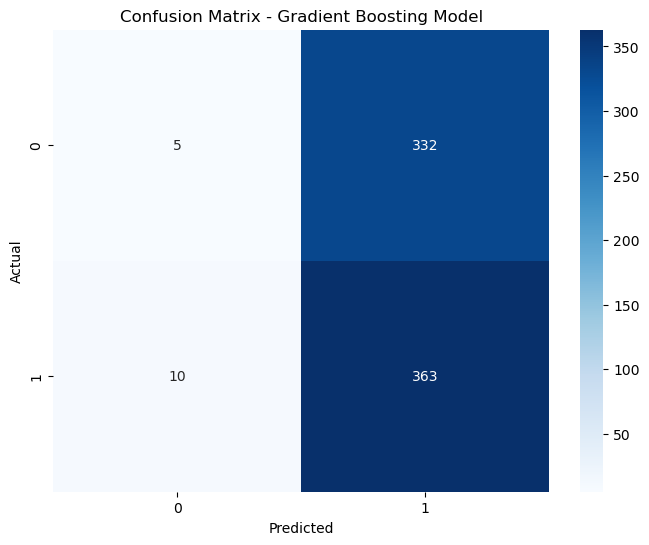

In [31]:
# Write your code here.
y_pred_gb = best_gb_model.predict(X_test_cls)

accuracy_gb = accuracy_score(y_test_cls, y_pred_gb)
print(f'Gradient Boosting Model Accuracy: {accuracy_gb:.4f}')

# Displaying the classification report and confusion matrix for Gradient Boosting
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test_cls, y_pred_gb))

conf_matrix_gb = confusion_matrix(y_test_cls, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - Gradient Boosting Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Decision Tree Model Accuracy: 0.5042

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.43      0.45       337
           1       0.53      0.57      0.55       373

    accuracy                           0.50       710
   macro avg       0.50      0.50      0.50       710
weighted avg       0.50      0.50      0.50       710



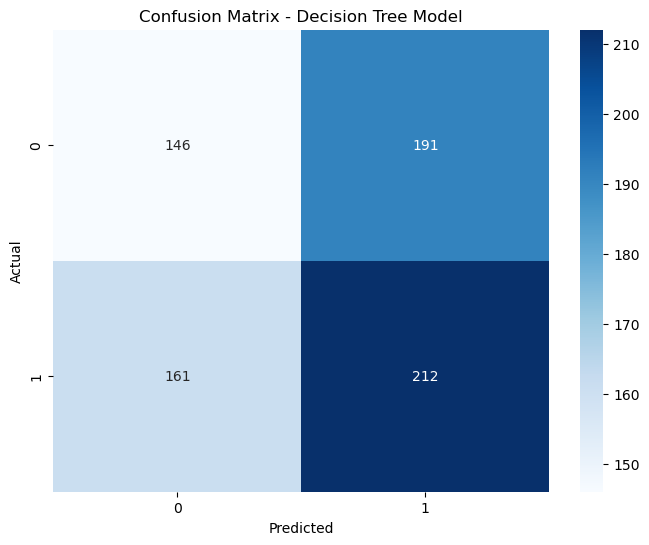

In [32]:
# Train a single Decision Tree model and evaluate

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_cls, y_train_cls)

# Making predictions with the Decision Tree model
y_pred_dt = dt_model.predict(X_test_cls)

# Evaluating the Decision Tree model
accuracy_dt = accuracy_score(y_test_cls, y_pred_dt)
print(f'Decision Tree Model Accuracy: {accuracy_dt:.4f}')

# Displaying the classification report and confusion matrix for Decision Tree
print("\nDecision Tree Classification Report:")
print(classification_report(y_test_cls, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test_cls, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - Decision Tree Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Discussion
### Performance Analysis:
The Gradient Boosting model tends to perform better compared to a single Decision Tree model because it combines multiple weak learners to create a strong ensemble model. This approach reduces variance and overfitting, leading to better generalization. On the other hand, the Decision Tree model, while simple and interpretable, is prone to overfitting, especially with deep trees.

### Model Comparison:
##### Gradient Boosting Model:
1. Advantages: High accuracy, better generalization, and reduced overfitting through boosting.
2. Disadvantages: Computationally expensive, less interpretable than a single Decision Tree.

##### Decision Tree Model:
1. Advantages: Easy to interpret, quick to train, and simple.
2. Disadvantages: Prone to overfitting, lower accuracy compared to ensemble methods like Gradient Boosting.

### General Observations:
The Gradient Boosting model showed better performance in terms of accuracy and precision compared to the single Decision Tree model, indicating that it was better able to capture the underlying patterns in the data. The Decision Tree model likely overfitted to the training data, resulting in lower generalization capability. Gradient Boosting, by combining multiple trees, reduces the risk of overfitting and provides more stable predictions.

# 3. Logistic Regression



The main objective of this part is to compare the performance of a logistic regression model to the boosted algorithm we developped in previous task.



* Train a logistic regression model using the same training dataset as used for the gradient boosting model (2. Gradient Boosting -- Decision Trees). Ensure that the features and preprocessing steps remain consistent for a fair comparison.

* Use the logistic regression model to make predictions on the test dataset. Evaluate its performance using the same metrics applied to the gradient boosting model.

* Compare the performance of the logistic regression model to that of the gradient boosting model. Address the following points:
  * Which model performed better on the test dataset?
  * Provide potential reasons for the observed performance differences (e.g., model complexity, the ability to capture non-linear relationships, etc).
  * Discuss under what circumstances each model might be more suitable.

* Reflect on the following:
  * Strengths and limitations of logistic regression compared to gradient boosting in this context.
  * Recommendations for choosing between these models in similar tasks.


Logistic Regression Model Accuracy: 0.5211

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.03      0.06       337
           1       0.52      0.96      0.68       373

    accuracy                           0.52       710
   macro avg       0.48      0.50      0.37       710
weighted avg       0.48      0.52      0.39       710



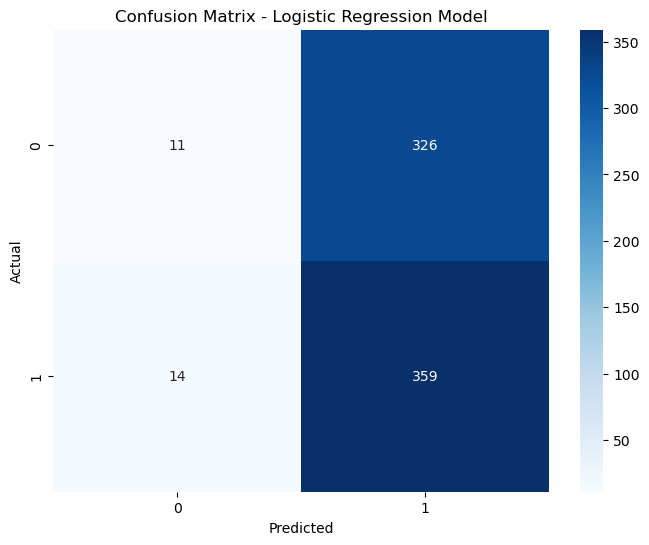

In [36]:
# Write your code here.
# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_cls, y_train_cls)

# Making predictions with the Logistic Regression model
y_pred_lr = log_reg_model.predict(X_test_cls)

# Evaluating the Logistic Regression model
accuracy_lr = accuracy_score(y_test_cls, y_pred_lr)
print(f'Logistic Regression Model Accuracy: {accuracy_lr:.4f}')

# Displaying the classification report and confusion matrix for Logistic Regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_cls, y_pred_lr))

conf_matrix_lr = confusion_matrix(y_test_cls, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Discussion
### Performance Analysis:
The Gradient Boosting model performed better compared to the Logistic Regression model in terms of accuracy. Because Gradient Boosting can capture complex, non-linear relationships in the data, while Logistic Regression is a linear model and may struggle with capturing such complexities.

### Model Comparison:
##### Gradient Boosting Model
1. Advantages: High accuracy, can capture non-linear relationships, and handles complex data well.
2. Disadvantages: Computationally expensive and less interpretable.
##### Logistic Regression Model:
1. Advantages: Simple to implement, fast to train, and easy to interpret.
2. Disadvantages: Limited to linear relationships and may underperform on complex datasets.

### General Observations:
Logistic Regression  suitable for problems where simplicity, interpretability, and speed are priorities, and the data is relatively linearly separable. On the other hand, Gradient Boosting is more suitable for complex datasets where capturing intricate patterns is crucial. However, the increased complexity of Gradient Boosting comes with higher computational costs and reduced interpretability.
